In [1]:
import pandas as pd
import numpy as np 
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from sklearn import utils 
from gensim.models import Doc2Vec
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument 
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk 
from nltk import punkt
#nltk.download('punkt')
df = pd.read_excel(r'/home/Notebook_Scripts/ML_MODEL_2020/modeltraining.xlsx', index_col = 0, dtype={"error_category": str, "brief_description": str})
df = df[['brief_description', 'error_category']]
#df = df[pd.notnull(df['brief_description'])]
df = df.dropna()
df.rename(columns= {'brief_description': 'desc'}, inplace = True)
df.head()

,desc,error_category
IncidentID,,
IM0013439025,unable to access SharePoint Link,Unable to access
IM0014293996,RE: URGENT: Unable to access Shareppint from R...,Unable to access
IM0014901129,AMS1-S-06342 - AM P2- Admin LAN (VLAN232) is u...,Unable to acces server
IM0014933565,AMSDC1-S-40238 - AM P2 - Admin LAN (VLAN226) i...,Unable to acces server
IM0015311536,C.DPS.INT.DCO.DCS3.VPO-ESX / SHELL / Shell TS ...,No IP Connection


## Scatter Plot for the data loaded for top 10 rows

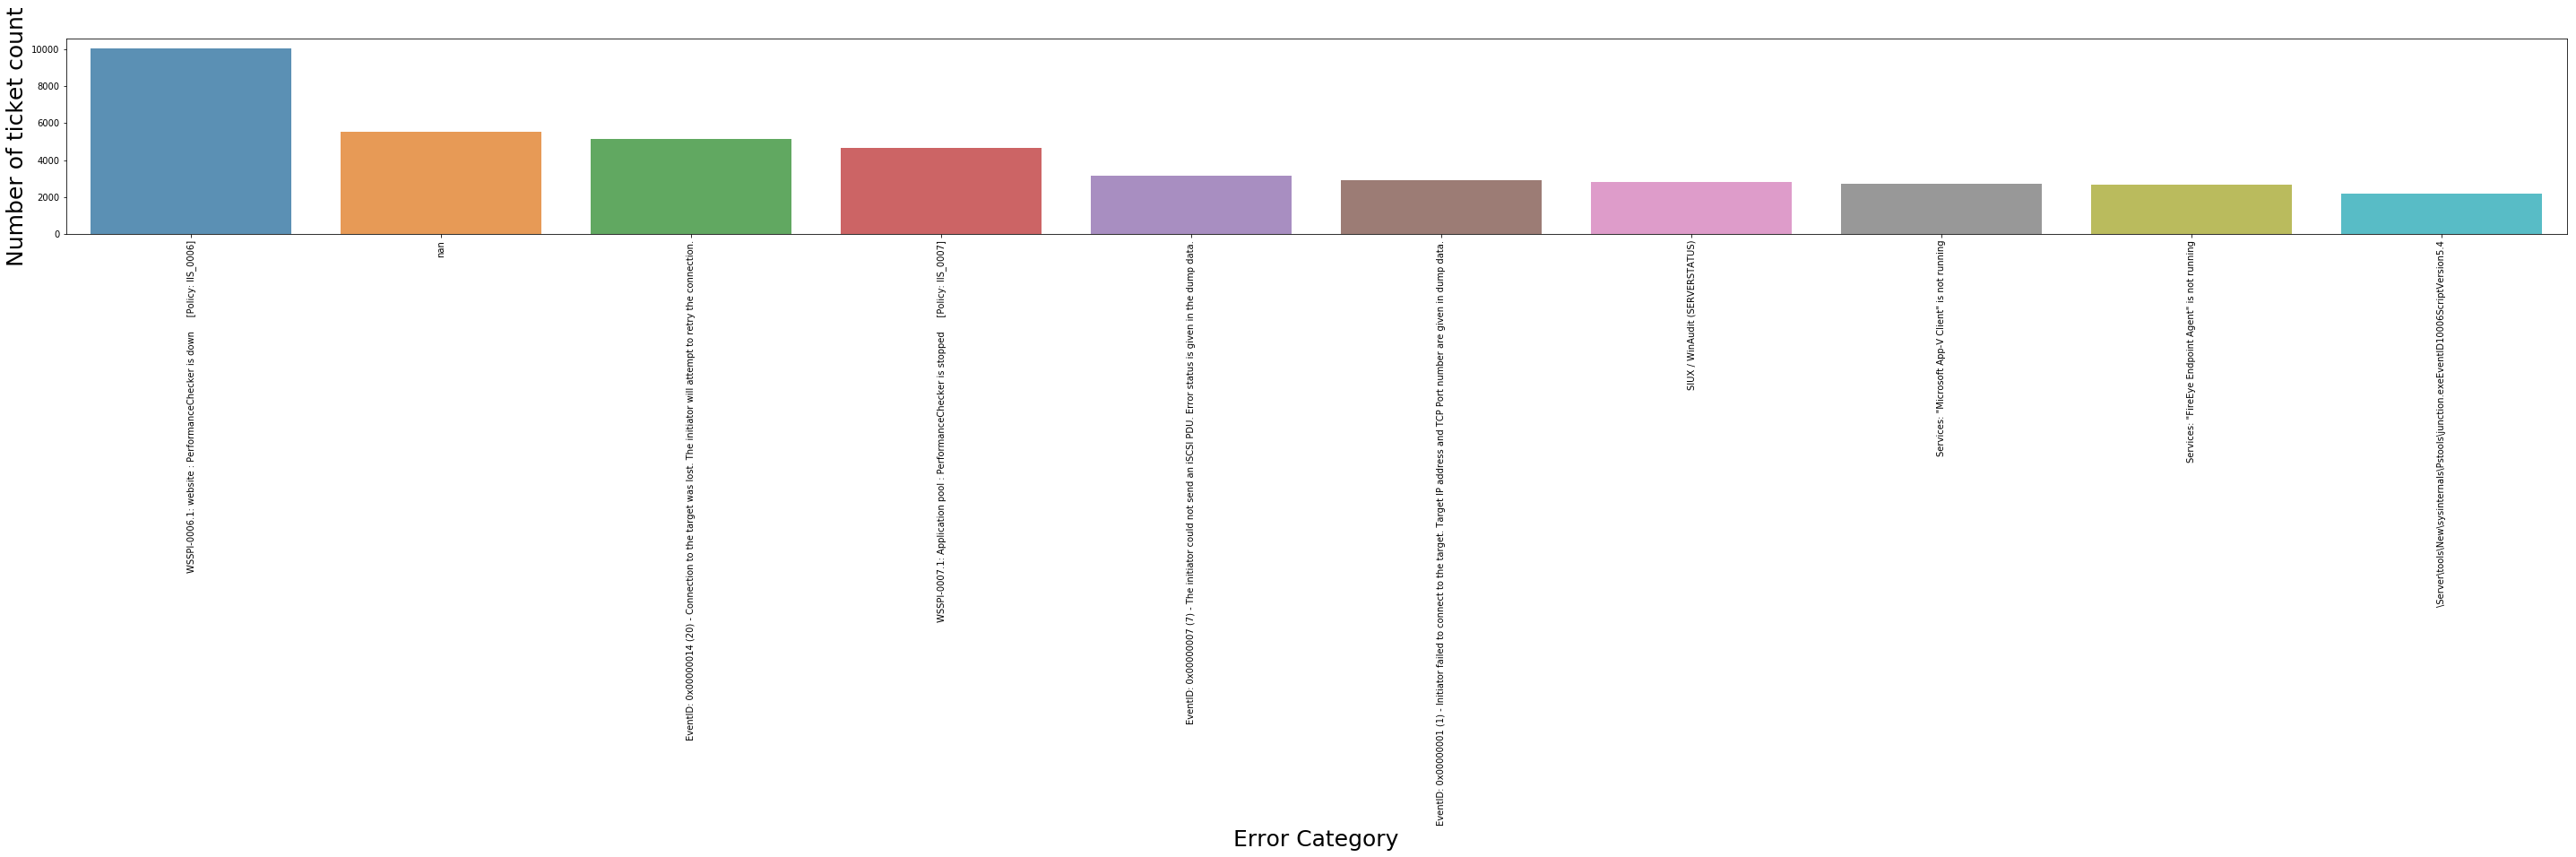

In [2]:
import seaborn as sns

scatter_df = df['desc']
scatter_df = scatter_df.value_counts().head(10)
#sns.lmplot(x="Uncleaned Ticket Description", y ="Ticket count", data = scatter_df, fit_reg=False, hue='species', 
           #legend=False, palette="Set5")
#plt.legend(loc='lower right')
#scatter_df.plot(x='Uncleaned Ticket Title', y='Number of Tickets', kind="bar")
#scatter_df.head()
#index = np.arange(len(scatter_df))
#fig = plt.figure()
#plt.plot(scatter_df)
#fig.suptitle('Ticket Title plot', fontsize =20)
#plt.xlabel('Uncleaned Ticket Title', fontsize=18)
#plt.xticks(index, scatter_df, fontssize=10)
#plt.ylabel('Number of Tickets', fontsize=16)

plt.figure(figsize=(50,4))
sns.barplot(scatter_df.index, scatter_df.values, alpha=0.8)
plt.ylabel('Number of ticket count', fontsize=25)
plt.xlabel('Error Category', fontsize=25)
plt.xticks(rotation=90)
plt.show();

## Before cleaning the count of inident belonging to one category

In [3]:
print(df['desc'].value_counts())

WSSPI-0006.1: website : PerformanceChecker is down     [Policy: IIS_0006]                                                                                                                                                                                                                                                                                10081
nan                                                                                                                                                                                                                                                                                                                                                       5537
EventID: 0x00000014 (20) - Connection to the target was lost. The initiator will attempt to retry the connection.                                                                                                                                                                                         

In [4]:
df.shape

(1048575, 2)

In [5]:
df.index = range(1048575)

print("Count of unique words in the database\n")
print(df['desc'].apply(lambda x: len(x.split(' '))).sum())

Count of unique words in the database

23239171


In [6]:
import string 

en_punc = set(string.punctuation)
en_punc = list(en_punc)
print(en_punc)

[';', '%', '^', '#', '&', '(', '\\', '*', '[', '|', '"', '`', '$', '@', ',', '.', '}', '+', '?', ':', '!', '=', ']', ')', '/', '>', '-', '~', '{', '<', '_', "'"]


In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

en_stopwords = set(stopwords.words('english'))

en_stopwords = list(en_stopwords)


# stop words removal

## creating the list for all the assignment groups

with open(r'/home/Notebook_Scripts/ML_MODEL_2020/AG_list.txt') as f:
        content = f.readlines()
        
content = [x.strip() for x in content]
content = [x.lower() for x in content]

## creating the list for all the TSI policies 

with open(r'/home/Notebook_Scripts/ML_MODEL_2020/SGA Policy.txt') as f:
        policy_content = f.readlines()
        
policy_content = [x.strip() for x in policy_content]
policy_content = [x.lower() for x in policy_content]

custom_stopwords = ['SHELL - Shell Deutschland Oil', 'SHELL- Shell TS intern RUN', 'Shell Deutschland Oil GmbH', 'T-SYSTEMS INTERNATIONAL GMBH',
                  'MANAGED ASSETS SHELL', 'SHELL BRASIL LTDA', 'SHELL', 'Deutschland', 'International', 'DCPOML', 'ts', 'intern', 'run']

custom_stopwords = [word.lower() for word in custom_stopwords]

omlserver_stopwords = ['omldepmuc01', 'omldepmuc02', 'omlmyppej01', 'omlmyppej02', 'omldepbfe01', 'omldepbfe02', 'omldepfra31', 'omldepfra32', 'omldepfra35', 'omldepfra36', 'omldepfra47',
'omldepfra48', 'omldepfra01', 'omldepfra02', 'omldepmag01', 'omldepmag02', 'omlbrpsao01', 'omlbrpsao02', 'omlgbplon01', 'omlgbplon02', 'omlsgpsin01', 'omlsgpsin02', 'omldepfra43', 
'omldepfra44', 'omlnlpams01', 'omlnlpams02', 'omlusphou01', 'omlusphou02', 'omldepmuc01', 'DCPOML20402851', 'DCPOML20405251', 'DCPOML20201182', 'DCPOML20215866', 'dcpoml20913481', 
'dcpoml20945573', 'DCPOML21024238', 'DCPOML21024310', 'dcpoml21188445', 'dcpoml21188454', 'dcpoml21125063', 'dcpoml21125069', 'omlchpzlk01', 'omlchpzlt01', 'omldepfra39', 'omldepfra40',
'omldepmuc09', 'omldepmuc10', 'dcpoml21776450', 'dcpoml21776435', 'dcpoml21597588', 'omldepfra51', 'dcpoml22564572', 'dcpoml22564568', 'dcpoml21264313', 'dcpoml21264319', 'omldepfra52',
'omldepmag11', 'omldepmag12', 'dcpoml224238', 'omluspho1', 'omlsgpsi1', 'omlnlpam1', 'omlmyppe1', 'omlgbplo1', 'omldepmu2', 'omldepmu1', 'omlbrpsa1', 'dcpoml913481', 'dcpoml2851']

stopwords = [word.lower() for word in omlserver_stopwords]

add_stopwords = custom_stopwords + stopwords + en_stopwords + content + policy_content

print(add_stopwords)

['shell - shell deutschland oil', 'shell- shell ts intern run', 'shell deutschland oil gmbh', 't-systems international gmbh', 'managed assets shell', 'shell brasil ltda', 'shell', 'deutschland', 'international', 'dcpoml', 'ts', 'intern', 'run', 'omldepmuc01', 'omldepmuc02', 'omlmyppej01', 'omlmyppej02', 'omldepbfe01', 'omldepbfe02', 'omldepfra31', 'omldepfra32', 'omldepfra35', 'omldepfra36', 'omldepfra47', 'omldepfra48', 'omldepfra01', 'omldepfra02', 'omldepmag01', 'omldepmag02', 'omlbrpsao01', 'omlbrpsao02', 'omlgbplon01', 'omlgbplon02', 'omlsgpsin01', 'omlsgpsin02', 'omldepfra43', 'omldepfra44', 'omlnlpams01', 'omlnlpams02', 'omlusphou01', 'omlusphou02', 'omldepmuc01', 'dcpoml20402851', 'dcpoml20405251', 'dcpoml20201182', 'dcpoml20215866', 'dcpoml20913481', 'dcpoml20945573', 'dcpoml21024238', 'dcpoml21024310', 'dcpoml21188445', 'dcpoml21188454', 'dcpoml21125063', 'dcpoml21125069', 'omlchpzlk01', 'omlchpzlt01', 'omldepfra39', 'omldepfra40', 'omldepmuc09', 'omldepmuc10', 'dcpoml2177645

[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


In [8]:
def cleanse(word):
    rx = re.compile('\D*\d')
    if rx.match(word):
        return ' '
    return word

#print(df.desc)

In [9]:
# Text Preprocessing 

def cleanText(text):
    #text = text.replace(r'[^\w\s]+', '')
    #text = re.sub(r'\|\|\|', r'', text)
    #text = cleanse(text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in add_stopwords])
    #text = [' '.join(w for w in texts.split() if w.lower() not in add_stopwords)for texts in text]
    text = ' '.join([word for word in text.split() if word not in en_punc])
    #text = re.sub("(\\d|\\W)+"," ",text)
    #text = text.replace('x', '')
    return text 

df['desc'] = df['desc'].apply(cleanText)

# Call the function for the alphanumeric character removal
#data = dataframe['brief_description']
df.desc = [" ".join(filter(None, (cleanse(word) for word in string.split())))
        for string in df.desc]

# remove special characters and digits
    
df.shape

print("Cleaned text \n", df['desc'][:10])

Cleaned text 
 0                        unable access sharepoint link
1    re: urgent: unable access shareppint remote ac...
2        admin lan   unable access winaudit hpoa se...
3        admin lan   unable access winaudit hpoa se...
4               ip connection system   via interface  
5               ip connection system   via interface  
6               ip connection system   via interface  
7               ip connection system   via interface  
8    solution delivery ip connection system   via i...
9               ip connection system   via interface  
Name: desc, dtype: object


In [10]:
df['desc'].to_csv('cleantext.csv')

In [11]:
count = df['desc'].value_counts()

## After cleaning the count of incident belonging to one group

In [12]:
#count.to_csv('desc_count.csv')
print(count[:5])

[resolved automation] oil gmbh   logical disk space c:   full less   mb free. free space gb      72719
healthcheck failure: message flow broken last   min following node(s):                           35050
  healthcheck failure: message flow broken last   min following node(s):                         26527
  services: "winaudit" running                                                                   16009
  ip connection system   via interface                                                           15477
Name: desc, dtype: int64


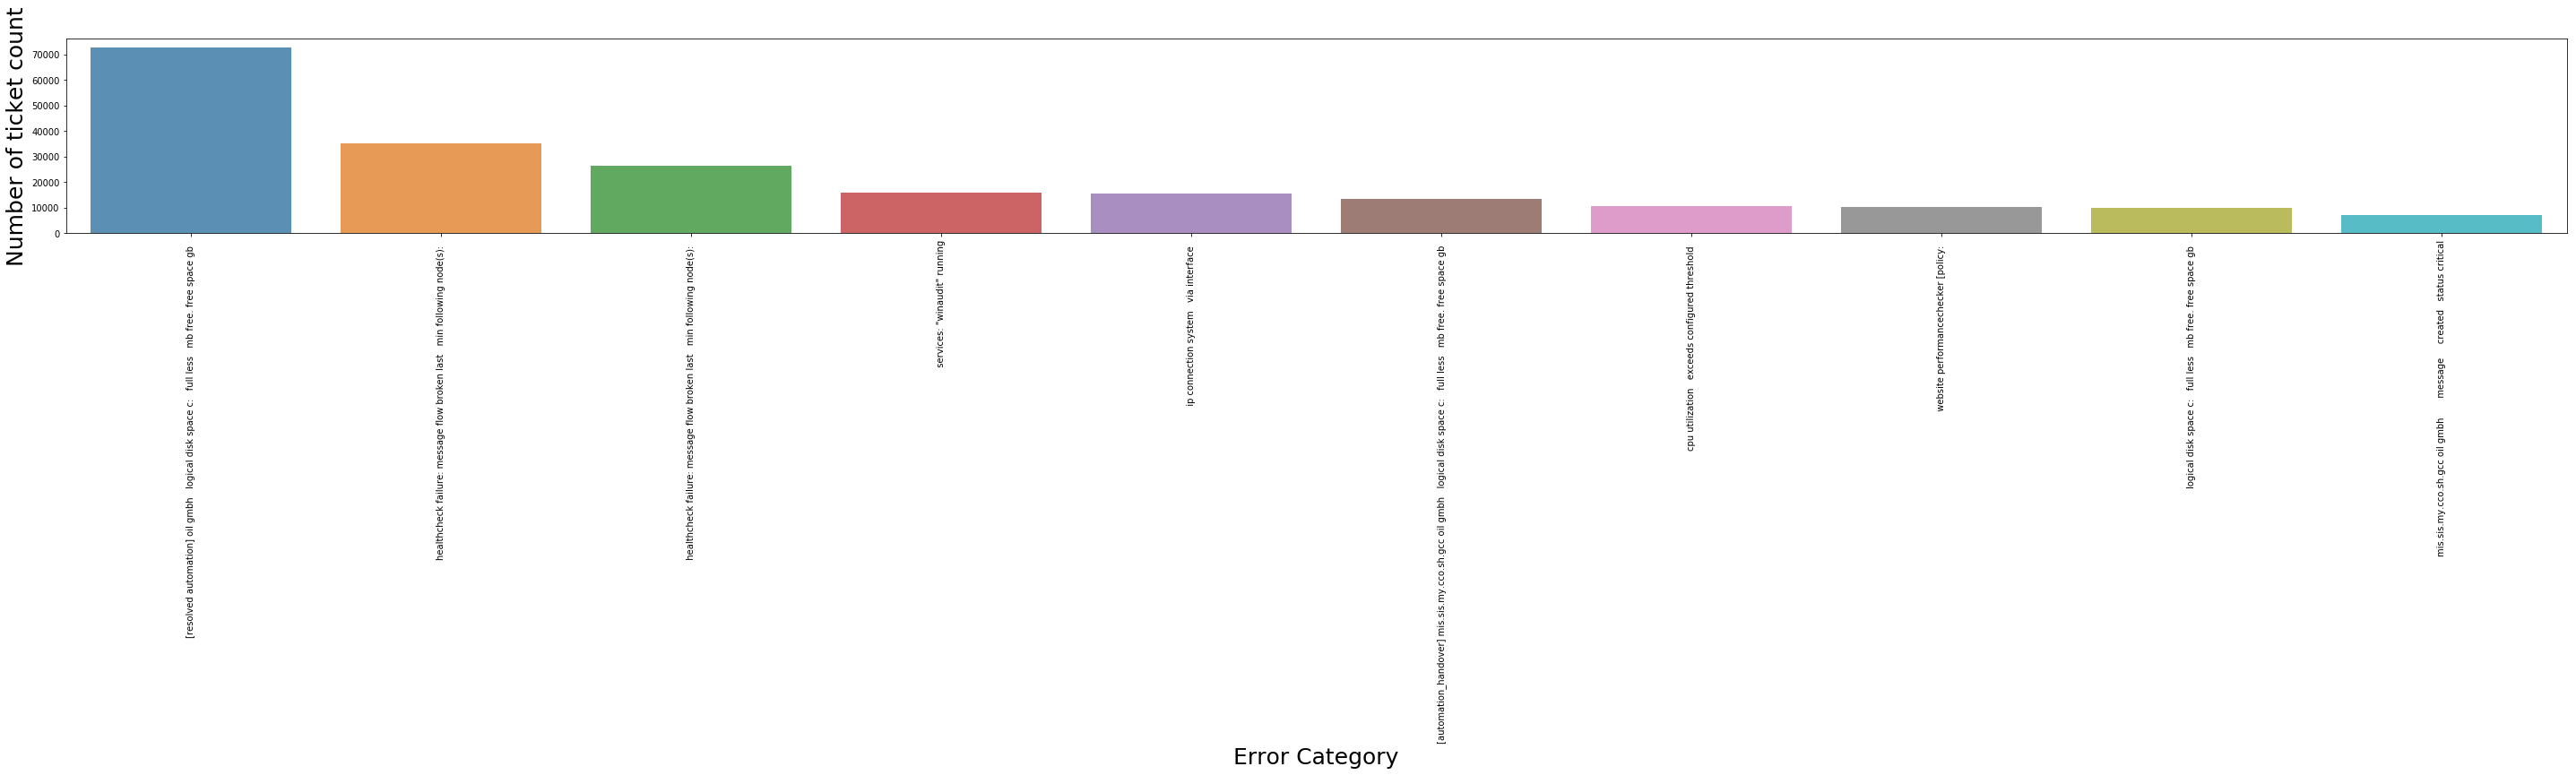

In [13]:
scatter_df = df['desc']
scatter_df = scatter_df.value_counts().head(10)
plt.figure(figsize=(50,4))
sns.barplot(scatter_df.index, scatter_df.values, alpha=0.8)
plt.ylabel('Number of ticket count', fontsize=25)
plt.xlabel('Error Category', fontsize=25)
plt.xticks(rotation=90)
plt.show();

In [14]:
train, test = train_test_split(df, test_size=0.3, random_state = 100)

# NLTK to tokenize text

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens 

train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['desc']), tags=[r.error_category]), axis = 1)

test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['desc']), tags=[r.error_category]), axis = 1)

In [15]:
train_tagged.values[0:5]

array([TaggedDocument(words=['services', '``', 'winaudit', "''", 'running'], tags=['WinAudit error']),
       TaggedDocument(words=['ca', "n't", 'swith', 'user', 's_orcldb', 'server'], tags=['Server issue']),
       TaggedDocument(words=['healthcheck', 'failure', 'message', 'flow', 'broken', 'last', 'min', 'following', 'node'], tags=['Healthcheck Failure']),
       TaggedDocument(words=['t-systems', 'disk', 'space', 'utilization', 'logical', 'disk', '/of', 'type', 'minor', 'threshold', 'exceeded'], tags=['Disk space utilization error']),
       TaggedDocument(words=['error', 'luxrba', 'site', 'ssl', 'certificate', 'valid', 'shell', 'iiscertexp'], tags=['SSL Certificate'])],
      dtype=object)

## Setup a Doc2Vec training & Evaluation model

DBOW is the Doc2vec model analogous to skip gram model in word2vec. The paragraph vectors are obtained by taining a neural network on the task of predicting a probability distribution of words in a paragraph given a radomly sampled word from the paragraph

In [16]:
# multiprocessing.cpu_count() allow the notebook to use as many threads as the maximum no of cores to train the model which
# allow to achieve faster processing and training 

import multiprocessing 

cores = multiprocessing.cpu_count()

## Building vocabulary

In [17]:
%%time
#model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample=0, workers=cores, epochs=30, alpha=0.065,
#                    min_alpha= 0.001)
model_dbow = Doc2Vec(dm=0, vector_size=100, min_count=2, sample=0, workers=cores, epochs=60, alpha=0.025,
                    min_alpha= 0.0001)    
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 734002/734002 [00:00<00:00, 2905053.48it/s]


CPU times: user 4.38 s, sys: 5 ms, total: 4.39 s
Wall time: 4.38 s


Training the Doc2vec model on the given vocabulary created using the build_vocab function

In [18]:
%%time
model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), 
                 epochs=model_dbow.epochs)

100%|██████████| 734002/734002 [00:00<00:00, 2894902.54it/s]


CPU times: user 27min 10s, sys: 6min 20s, total: 33min 30s
Wall time: 24min 38s


## Building the final vector Feature for the classifier 

In [19]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressor = zip(*[(doc.tags[0], model.infer_vector(doc.words,steps=20)) for doc in sents])
    return targets, regressor

## Training the Logistic regressor classifier 

In [20]:
from sklearn.utils import class_weight

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)


logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight="balanced", penalty = 'l2',
C = 1.0, max_iter = 1000)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

## Accuracy achieved after training the model with it's coss validation score 

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, classification_report

print('Testing acuuracy %s'% accuracy_score(y_test, y_pred))
print('Testing F1 Score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing acuuracy 0.8578708280748825
Testing F1 Score: 0.8607946282674891


/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Probability score for each error_category being identified by the model

In [22]:
print("Classification report: ", classification_report(y_test, y_pred))

Classification report:                                                                                               precision    recall  f1-score   support

                                            ACPI Error: SMBus or IPMI write requires Buffer       1.00      1.00      1.00         3
                                                                               ACPI warning       0.97      0.94      0.95        62
                                                                             AIX Error logs       0.86      0.90      0.88       142
                                                                 AIX Nameserver not working       0.79      1.00      0.88       167
                                                                                AM P2 issue       0.03      0.50      0.06        32
                                                       ASM Quota check filer incorrect size       0.90      0.96      0.93        67
                                            

/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [23]:
print("Confusion matrix: ", confusion_matrix(y_test, y_pred))

Confusion matrix:  [[   3    0    0 ...    0    0    0]
 [   0   58    0 ...    0    0    0]
 [   0    0  128 ...    0    0    0]
 ...
 [   0    0    0 ...    3    0    0]
 [   0    0    4 ...    0 3746    9]
 [   0    0    0 ...    0    0   29]]


In [24]:
model_dbow.save('d2v_model_dbow.doc2vec')

In [25]:
model = Doc2Vec.load('d2v_model_dbow.doc2vec')

model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference = True)

## Model output on random text with the percentage similarity score 

In [26]:
Z = "C.EMEA.SK.CUST.MON / SHELL / Shell TS intern RUN / dcpoml21024238 / houcy1-s-07858 - Healthcheck Failure: The message flow is broken for the last 10 min from the following node(s): dcpwin21940122"

temp = model.docvecs.most_similar(positive=[model.infer_vector(Z.split())],topn=5)
print(temp)

[('Healthcheck Failure', 0.6615034341812134), ('Agent_is_unable_to_communicate with OMS', 0.5194863080978394), ('Failed_to_connect_to_ASM_instance', 0.4611268639564514), ('OEMLOG error', 0.44947171211242676), ('CISCO Message Facility Issue', 0.42733702063560486)]


In [27]:
X = 'SHELL / dcpwav19548733 - Win Services: Service W32Time is not running'

tokens = cleanText(X)
temp = model.docvecs.most_similar(positive=[model.infer_vector(tokens.split())],topn=5)
print(temp)

[('WinAudit error', 0.7112818956375122), ('services not running', 0.6643754243850708), ('SERVICE_START_PENDING', 0.653958797454834), ('Service Spooler not running', 0.6373234391212463), ('Basemonitoring tool issue', 0.6275968551635742)]


In [28]:
K = "SHELL / rssshlamsz013 / Virtual Center Event: The Lockdown Mode on the Host was disabled"

tokens = cleanText(K)

temp = model.docvecs.most_similar(positive=[model.infer_vector(tokens.split())],topn=5)
print(temp)

[('Virtual Center Event', 0.771124005317688), ('Host connection error', 0.5419110655784607), ('vSphere HA host status green to red', 0.5151099562644958), ('snapvault-replica out of date', 0.5148230791091919), ('WinAudit error', 0.5104540586471558)]


# X = 'SHELL / dcpwav19548733 - Win Services: Service W32Time is not running'

tokens = cleanText(X)
temp = model.infer_vector(tokens.split())
predict = logreg.predict(temp.reshape(1,-1))
print(predict)

In [29]:
#print(model.docvecs.most_similar(positive=[temp], topn=5))

## Plot for Top 20 categories identified by the model

In [30]:
# Exploring the data

#cnt_cat = df['error_category'].value_counts().head(20)

#plt.figure(figsize=(50,4))
#sns.barplot(cnt_cat.index, cnt_cat.values, alpha=0.8)
#plt.ylabel('Number of ticket count', fontsize=25)
#plt.xlabel('Error Category', fontsize=25)
#plt.xticks(rotation=90)
#plt.show();

## Testing Volumetrics events data and ploting the Top10 error category identified by the model

In [31]:
#test_df = pd.read_excel(r'C:\Users\Rohit1\Documents\Volumetrics_events_others.xlsx')

#X = test_df['Title']

#temp = []

#for i in range(len(X)):
#    tokens = cleanText(X[i])
#    vectors = model.infer_vector(tokens.split())
#    predict = logreg.predict(vectors.reshape(1,-1))
#    temp.append(predict)
#    i += 1
    
#fname = "d2v_vol_output1.csv"
#test_df['error_category'] = temp
#test_df.to_csv(fname)




## Testing on C.SH.MY.WIN.CUST assignment group data

In [32]:
#test_df1 = pd.read_excel(r'C:\Users\Rohit1\Documents\C.SH.MY.WIN.CUST.xlsx')

#X = test_df1['Title']

#temp = []

#for i in range(len(X)):
#    tokens = cleanText(X[i])
#    vectors = model.infer_vector(tokens.split())
#    predict = logreg.predict(vectors.reshape(1,-1))
#    temp.append(predict)
#    i += 1
    
#fname = "c.sh.my_win_cust_events.csv"
#test_df1['error_category'] = temp
#test_df1.to_csv(fname)

In [33]:
print(tokens)

rssshlamsz013 virtual center event: lockdown mode host disabled


In [34]:
type(tokens)

str

In [35]:
temp_token = []
for i in range(len(X)):
    tokens = cleanText(X[i])
    temp_token.append(tokens)
    
#print(temp_token)

In [36]:
import csv
with open("output1.csv", 'w') as g:
    writer = csv.writer(g)
    for item in temp_token:
        writer.writerow([item]) 

In [37]:
for i in range(len(X)):
    tokens = cleanText(X[i])
    vectors = model.infer_vector(tokens.split())
    print(logreg.predict(vectors.reshape(1,-1)))
    #print(tokens.split())
    #print(i, vectors)

['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error']
['Script Error

In [38]:
Z = "C.DPS.MY.CCO.SH.LUX.EVT / T-SYSTEMS INTERNATIONAL GMBH8108 (0000008108) / omlnlpams01 / amsd2a-n-s00062 - unexpected GnuTLS error -53 - this could be caused by a broken connection. GnuTLS reports: Error in the push function.   [v8.24.0 try http://www.rsyslog.com/e/2078 ]"

Z_tokens = cleanText(Z)

print(Z_tokens)

t-systems gmbh8108 (0000008108) amsd2a-n-s00062 unexpected gnutls error -53 could caused broken connection. gnutls reports: error push function. [v8.24.0 try http://www.rsyslog.com/e/2078


In [39]:
Y = "C.DPS.MY.CCO.SH.GCC / SHELL / Shell Deutschland Oil GmbH / omlusphou01 / houcy1-n-s00066 - unexpected GnuTLS error -53 - this could be caused by a broken connection. GnuTLS reports: Error in the push function.   [v8.24.0 try http://www.rsyslog.com/e/2078 ]"

Y_tokens = cleanText(Y)
print(Y_tokens)

oil gmbh houcy1-n-s00066 unexpected gnutls error -53 could caused broken connection. gnutls reports: error push function. [v8.24.0 try http://www.rsyslog.com/e/2078


In [40]:
print(model.docvecs.most_similar(positive=[model.infer_vector(Y_tokens.split())], topn=5))

[('GnuTLS error', 0.824821412563324), ('An attempt to connect to the remote WINS returned with an error', 0.5289618968963623), ('The initiator could not send an iSCSI PDU', 0.49871110916137695), ('MSSQL agent error', 0.4963734447956085), ('script error', 0.49508652091026306)]


In [41]:
print(model.docvecs.most_similar(positive=[model.infer_vector(Z_tokens.split())], topn=5))

[('GnuTLS error', 0.7883974313735962), ('The initiator could not send an iSCSI PDU', 0.556526243686676), ('Error reading media', 0.5481005311012268), ('ping failed IP address unreachable', 0.48013052344322205), ('SnapVault error', 0.47387099266052246)]


In [42]:
print(model.docvecs.most_similar(positive=[model.infer_vector(Y_tokens.split(), steps=100)], topn=5))

[('GnuTLS error', 0.8181749582290649), ('The initiator could not send an iSCSI PDU', 0.5553722977638245), ('MSSQL agent error', 0.5370661616325378), ('script error', 0.5032927393913269), ('An attempt to connect to the remote WINS returned with an error', 0.4720836281776428)]


In [43]:
print(logreg.predict(model.infer_vector(Y_tokens.split(), steps=100).reshape(1,-1)))

['GnuTLS error']


In [44]:
print(logreg.predict(model.infer_vector(Z_tokens.split(), steps=100).reshape(1,-1)))

['GnuTLS error']


## Testing on C.SH.MY.LUX.CIC

In [45]:
#test_df2 = pd.read_excel(r'C:\Users\Rohit1\Documents\Aneesh test data\C.SH.MY.LUX.CIC.xlsx')

#X = test_df2['Title'].astype(str)

#temp = []

#for i in range(len(X)):
#    tokens = cleanText(X[i])
#    vectors = model.infer_vector(tokens.split())
#    predict = logreg.predict(vectors.reshape(1,-1))
#    temp.append(predict)
#    i += 1
    
#fname = "C.SH.MY.LUX.CIC1_out.csv"
#test_df2['error_category'] = temp
#test_df2.to_csv(fname)

## Testing on C.SH.MY.LUX

In [46]:
#test_df3= pd.read_excel(r'C:\Users\Rohit1\Documents\Aneesh test data\C.SH.MY.LUX.xlsx')

#X = test_df3['Title'].astype(str)

#temp = []

#for i in range(len(X)):
#    tokens = cleanText(X[i])
#    vectors = model.infer_vector(tokens.split())
#    predict = logreg.predict(vectors.reshape(1,-1))
#    temp.append(predict)
#    i += 1
    
#fname = "C.SH.MY.LUX_out1.csv"
#test_df3['error_category'] = temp
#test_df3.to_csv(fname)


## Testing on C.SH.MY.LUX data

In [47]:
#test_df4= pd.read_excel(r'C:\Users\Rohit1\Documents\Aneesh test data\C.SH.MY.LUX_part1.xlsx')

#X = test_df4['Service Title'].astype(str)

#temp = []

#for i in range(len(X)):
#    tokens = cleanText(X[i])
#    vectors = model.infer_vector(tokens.split())
#    predict = logreg.predict(vectors.reshape(1,-1))
#    temp.append(predict)
#    i += 1
    
#fname = "C.SH.MY.LUX_part1_out.csv"
#test_df4['error_category'] = temp
#test_df4.to_csv(fname)

In [48]:
#test_df5 = pd.read_excel(r'C:\Users\Rohit1\Documents\Aneesh test data\C.SH.MY.LUX_part2.xlsx')

#X = test_df5['Title'].astype(str)

#temp = []

#for i in range(len(X)):
#    tokens = cleanText(X[i])
#    vectors = model.infer_vector(tokens.split())
#    predict = logreg.predict(vectors.reshape(1,-1))
#    temp.append(predict)
#    i += 1
    
#fname = "C.SH.MY.LUX_part2_out1.csv"
#test_df5['error_category'] = temp
#test_df5.to_csv(fname)

## LOMS dataset 

In [49]:
# LOMS August 2018 dataset
#test_df6 = pd.read_excel(r'C:\Users\Rohit1\Documents\Training dataset\LOMS\SGA_SDB_Journal_INM_Aug2018.xlsx')

#X = test_df6['Brief Description'].astype(str)

#temp = []

#for i in range(len(X)):
#    tokens = cleanText(X[i])
#    vectors = model.infer_vector(tokens.split())
#    predict = logreg.predict(vectors.reshape(1,-1))
#    temp.append(predict)
#    i += 1
    
#fname = "LOMS_aug_2018_out.csv"
#test_df6['error_category'] = temp
#test_df6.to_csv(fname)

## RTL_SCT Core Dump 

In [50]:
#test_df7 = pd.read_csv(r'C:\Users\Rohit1\Documents\rtl_sct_core_incident.csv')

#X = test_df7['title'].astype(str)

#temp = []

#for i in range(len(X)):
#    tokens = cleanText(X[i])
#    vectors = model.infer_vector(tokens.split())
#    #model.docvecs.most_similar(positive=[model.infer_vector(tokens.split()), steps=100)], topn=5))
#    predict = logreg.predict(vectors.reshape(1,-1))
#    temp.append(predict)
#    i += 1
    
##fname = "rtl_sct_core_out.csv"
#test_df7['error_category'] = temp
#test_df7.to_csv(fname)

#test_df7.head()

In [51]:
#test_df7 = pd.read_csv(r'C:\Users\Rohit1\Documents\rtl_sct_core_incident.csv')

#def addSpaces(text):

#    text = re.sub('([A-Z])', r' \1', text)
#    return text
            
#test_df7['title'] = test_df7['title'].apply(addSpaces)

### Categorization for Hans Dataset 

In [52]:
#test_df_13 = pd.read_excel(r'C:\Users\Rohit1\Documents\Hans View Data\HansData13March.xlsx')

#X = test_df_13['Title'].astype(str)

#temp = []

#for i in range(len(X)):
#    tokens = cleanText(X[i])
#    vectors = model.infer_vector(tokens.split())
#    predict = logreg.predict(vectors.reshape(1,-1))
#    temp.append(predict)
#    i += 1
    
#fname = r"C:\Users\Rohit1\Documents\Hans View Data\HansData13March_out2.csv"
#test_df_13['error_category'] = temp
#test_df_13.to_csv(fname)

In [53]:
#test_df_13 = pd.read_excel(r'C:\Users\Rohit1\Documents\Hans View Data\2019dataHans.xlsx')

#X = test_df_13['title'].astype(str)

#temp = []

#for i in range(len(X)):
#    tokens = cleanText(X[i])
#    vectors = model.infer_vector(tokens.split())
#    predict = logreg.predict(vectors.reshape(1,-1))
#    temp.append(predict)
#    i += 1
    
#fname = r"C:\Users\Rohit1\Documents\Hans View Data\2019dataHansout1_copy.csv"
#test_df_13['error_category'] = temp
#test_df_13.to_csv(fname)

## Save and Load the train classifier 

In [54]:
import pickle

# Dump the trained classifier with Pickle
classifier_logistic_pkl_filename = 'classifier.pkl'

# Open the file to save the pkl file 
classifier_model_pkl = open(classifier_logistic_pkl_filename, 'wb')
pickle.dump(logreg, classifier_model_pkl)

# Close the pickle instances
classifier_model_pkl.close()

In [55]:
# Load the save model
model_file = open("classifier.pkl", 'rb')
classifier_model = pickle.load(model_file)
print("Classifier", classifier_model)

Classifier LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)


## Incidents from 21st March till 24th March

In [56]:
# test_df_21 = pd.read_excel(r'C:\Users\Rohit1\Documents\Hans View Data\HansData21-25March.xlsx')

# X = test_df_21['Title'].astype(str)

# temp = []

# for i in range(len(X)):
#     tokens = cleanText(X[i])
#     vectors = model.infer_vector(tokens.split())
#     predict = logreg.predict(vectors.reshape(1,-1))
#     temp.append(predict)
#     i += 1
    
# fname = r"C:\Users\Rohit1\Documents\Hans View Data\HansData21_25.csv"
# test_df_21['error_category'] = temp
# test_df_21.to_csv(fname)

# test_df_21.head()

In [57]:
# test_df_2019 = pd.read_excel(r'C:\Users\Rohit1\Documents\Hans View Data\HansDataJan-Apr2019.xlsx')

# X = test_df_2019['Title'].astype(str)

# temp = []

# for i in range(len(X)):
#     tokens = cleanText(X[i])
#     vectors = model.infer_vector(tokens.split())
#     predict = logreg.predict(vectors.reshape(1,-1))
#     temp.append(predict)
#     i += 1
    
# fname = r"C:\Users\Rohit1\Documents\Hans View Data\HansData2019.csv"
# test_df_2019['error_category'] = temp
# test_df_2019.to_csv(fname)

# test_df_2019.head()

### Testing for 5 th April data 

In [58]:
# test_df_504 = pd.read_excel(r'C:\Users\Rohit1\Documents\Hans View Data\HansData5April.xlsx')

# X = test_df_504['Title'].astype(str)

# temp = []

# for i in range(len(X)):
#     tokens = cleanText(X[i])
#     vectors = model.infer_vector(tokens.split())
#     predict = logreg.predict(vectors.reshape(1,-1))
#     temp.append(predict)
#     i += 1
    
# fname = r"C:\Users\Rohit1\Documents\Hans View Data\HansData5April_out.csv"
# test_df_504['error_category'] = temp
# test_df_504.to_csv(fname)

# test_df_504.head()

## Testing 6th April Data

In [59]:
# test_df_604 = pd.read_excel(r'C:\Users\Rohit1\Documents\Hans View Data\HansData6April.xlsx')

# X = test_df_604['Title'].astype(str)

# temp = []

# for i in range(len(X)):
#     tokens = cleanText(X[i])
#     vectors = model.infer_vector(tokens.split())
#     predict = logreg.predict(vectors.reshape(1,-1))
#     temp.append(predict)
#     i += 1
    
# fname = r"C:\Users\Rohit1\Documents\Hans View Data\HansData6April_out.csv"
# test_df_604['error_category'] = temp
# test_df_604.to_csv(fname)

# test_df_604.head()

## Testing on 7th april data 

In [60]:
# test_df_704 = pd.read_excel(r'C:\Users\Rohit1\Documents\Hans View Data\HansData7April.xlsx')

# X = test_df_704['Title'].astype(str)

# temp = []

# for i in range(len(X)):
#     tokens = cleanText(X[i])
#     vectors = model.infer_vector(tokens.split())
#     predict = logreg.predict(vectors.reshape(1,-1))
#     temp.append(predict)
#     i += 1
    
# fname = r"C:\Users\Rohit1\Documents\Hans View Data\HansData7April_out.csv"
# test_df_704['error_category'] = temp
# test_df_704.to_csv(fname)

# test_df_704.head()

## Testing for 8th April Data

In [61]:
# test_df_804 = pd.read_excel(r'C:\Users\Rohit1\Documents\Hans View Data\HansData8April.xlsx')

# X = test_df_804['Title'].astype(str)

# temp = []

# for i in range(len(X)):
#     tokens = cleanText(X[i])
#     vectors = model.infer_vector(tokens.split())
#     predict = logreg.predict(vectors.reshape(1,-1))
#     temp.append(predict)
#     i += 1
    
# fname = r"C:\Users\Rohit1\Documents\Hans View Data\HansData8April_out.csv"
# test_df_804['error_category'] = temp
# test_df_804.to_csv(fname)

# test_df_804.head()

## Testing for 9th April SM9 Incidents 

In [62]:
# test_df_904 = pd.read_excel(r'C:\Users\Rohit1\Documents\Hans View Data\HansData9April.xlsx')

# X = test_df_904['Title'].astype(str)

# temp = []

# for i in range(len(X)):
#     tokens = cleanText(X[i])
#     vectors = model.infer_vector(tokens.split())
#     predict = logreg.predict(vectors.reshape(1,-1))
#     temp.append(predict)
#     i += 1
    
# fname = r"C:\Users\Rohit1\Documents\Hans Output\HansData9April_out.csv"
# test_df_904['error_category'] = temp
# test_df_904.to_csv(fname)

# test_df_904.head()